# Theoretical Computer Sciences Project

#### Sergio Peignier and Théotime Grohens

 **Libraries to install before starting** :

`pip install pqdict`

`pip install community`

`pip install python-louvain`

In [1]:
import random
import pqdict
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import community as community_louvain
import math 
from scipy import stats as st

## 1 - Graph Therory

In this project we will apply graph algorithms to study the gene regulatory network (GRN)
of *Saccharomyces cerevisiae*. This species of yeast, it is a small single-cell eukaryote, with a short generation time, and two possible forms: an haploid one and a diploid one. Moreover, this organism can be easily cultured, and it has an important economic impact since it is extensively used for instance,
in winemaking, baking, and brewing. Due to these characteristics, Saccharomyces cerevisiae
is studied as an important model organism.

In this work we will study the **gene regulatory network** of *Saccharomyces cerevisiae*, using graph theory algorithms. The files that are provided for this project have been used in [MCK+12] , as gold-standards to assess gene regulatory network inference algorithms, and they are the result of biological experiments based on ChIP binding data [MWG + 06], and systematic transcription factor deletions [HKI07]. Hereafter we describe each dataset in details:

- GRN_edges_S_cerevisiae.txt : contains the edges of the *S. cervisiae* regulatory network (from transcription factors to target genes). The intended meaning is that if there is an edge between transcription factor X and the target gene A, then X regulates the transcription of A ;

- net4_transcription_factors.tsv : Is a file containing in a single column the identifiers of the transcription factors of *S. cervisiae* that were studied ;

- net4_gene_ids.tsv : The two previous files, use specific identifiers to denote genes, and this file contains the gene name associated to each gene identifier ;

- go_slim_mapping.tab.txt : Only columns 0 and 5 will be used in this work. Column 0 contains the gene name, and column 5 contains its Gene Ontology (GO) annotation (http://www.geneontology.org/). Notice that two different rows may give for the same gene different Gene Ontology annotations. 

### 1.1 - Exploration and characterization of the gene regulatory network

#### 1.1.1 - Load the dataset and create a NetworkX graph instance.

On importe les datasets avec pandas : 

In [2]:
# X : transcription factors
# A : genes
GRN_edges_SC = pd.read_csv("./datas/GRN_edges_S_cerevisiae.txt", sep = ',',  header=0) # edges X -> A
net4_transcription_factors = pd.read_csv("./datas/net4_transcription_factors.tsv", sep = '\n',  header=0) # X ID
net4_gene_ids = pd.read_csv("./datas/net4_gene_ids.tsv", sep = '\t', header=0) # A ID -> Name
go_slim_mappingtab = pd.read_csv("./datas/go_slim_mapping.tab.txt", sep = '\t', header=None) # A [0]Name -> [5]GO 

In [3]:
GRN_edges_SC = GRN_edges_SC.iloc[:,1:] # the first column isn't relevant

On vérifie que tout a bien été importé 

In [4]:
# on peut transformer le df en array (au cas où si besoin)
GRN_edges_SC_np = GRN_edges_SC.to_numpy()

In [5]:
net4_gene_ids.head()

,ID,Name
0,G1,YHR084W
1,G2,YER109C
2,G3,YDR496C
3,G4,YBR098W
4,G5,YNL139C


In [6]:
net4_transcription_factors.head()

,transcription_factor
0,G1
1,G2
2,G3
3,G4
4,G5


In [7]:
go_slim_mappingtab.head()

,0,1,2,3,4,5,6
0,HRA1,HRA1,S000119380,C,cellular_component,GO:0005575,ncRNA_gene
1,HRA1,HRA1,S000119380,F,molecular_function,GO:0003674,ncRNA_gene
2,HRA1,HRA1,S000119380,P,rRNA processing,GO:0006364,ncRNA_gene
3,HRA1,HRA1,S000119380,P,ribosomal small subunit biogenesis,GO:0042274,ncRNA_gene
4,ICR1,ICR1,S000132612,C,nucleus,GO:0005634,ncRNA_gene


In [8]:
GRN_edges_SC.head()

,transcription_factor,target_gene
0,G15,G1
1,G98,G1
2,G109,G1
3,G22,G9
4,G211,G11


Le dataset a bien été importé, on créé donc un graphe $G = <V,E>$ dont l'ensemble des noeuds noté $V$ contient les facteurs de transcription et les gènes cibles et l'ensemble des arettes noté $E$ représente les régulations des gènes par les facteurs de transcription.

In [9]:
G = nx.from_pandas_edgelist(GRN_edges_SC, "transcription_factor", "target_gene")

#### 1.1.2 - Plot the gene regulatory network,  the plot should be readable,  understandable,  andinformative.  Which information did you decide to convey in your plot?  Why?

On représente le graphe G tel quel.

In [ ]:
#Premiere impression pour le graphe 
plt.figure(figsize=(15,8))
nx.draw(G, node_size = 12)

L'ensemble $V$ peut être séparé en deux sous-ensembles :

- $X$ : ensemble des facteurs de transcription ;
- $A$ : ensemble des gènes.

In [10]:
#gn_nodes = [a for a in GRN_edges_SC["target_gene"]]
#tf_nodes = [x for x in GRN_edges_SC["transcription_factor"]]
tf_nodes = []
for x in GRN_edges_SC["transcription_factor"] :
    if x not in tf_nodes :
        tf_nodes.append(x)
gn_nodes = []
for a in GRN_edges_SC["target_gene"] :
    if a not in gn_nodes and a not in tf_nodes:
        gn_nodes.append(a)

In [ ]:
pos = nx.kamada_kawai_layout(G)

In [ ]:
#pos = nx.spring_layout(G, k=0.6) #return the relative positions of the nodes,k = optimal distance between nodes

In [ ]:
#On rend le graphe plus lisible 
plt.figure(figsize=(18,10))


# nodes
nx.draw_networkx_nodes(G, pos, nodelist=gn_nodes, node_color="r", node_size= 18, label = "gene's nodes")
nx.draw_networkx_nodes(G, pos, nodelist=tf_nodes, node_color="b", node_size= 18, label = "TGF's nodes")

# edges
nx.draw_networkx_edges(G, node_size = 18, pos = pos, width = 0.4, edge_color = 'DarkSlateGray')

plt.legend()
plt.axis('off')
plt.show()

#### If it's a Bipartite Graph :

In [ ]:
# from networkx.algorithms import bipartite # on a déjà importé tout networkX pas la peinne de réimporter bipartite ?

In [ ]:
BG =  nx.Graph()
BG.add_nodes_from(GRN_edges_SC['transcription_factor'], bipartite = 'transcription_factor')
BG.add_nodes_from(GRN_edges_SC['target_gene'], bipartite = 'target_gene')
BG.add_edges_from(zip(GRN_edges_SC['transcription_factor'], GRN_edges_SC['target_gene']))

In [ ]:
#tf = transcription_factor
tf_nodes0 = [ n for n in BG.nodes() if BG.nodes[n]
            ['bipartite'] == 'transcription_factor']

# gn = gene = target_gene
gn_nodes0 = [ n for n in BG.nodes() if BG.nodes[n]
           ['bipartite'] == 'target_gene']

In [ ]:
print(len(tf_nodes))
print(len(tf_nodes0))
len(tf_nodes0)+len(gn_nodes0)==len(G.nodes())

In [ ]:
posBG = nx.bipartite_layout(BG, tf_nodes0, scale = 1)
plt.figure(figsize=(30,20))
nx.draw(BG, pos = posBG, node_size = 14,
       node_color = 'forestgreen',
       edge_color = 'darkblue',
       width = 0.1)


On the graph above we have a sight of our graph *G* if this one was bipartite 

- On the left side : nodes that represent the transcription factors ;

- On the right side : nodes that represent the target genes to apply a regulation.

FInaly it is immediately noticeable that certain factors act on a greater number of target genes than others.

#### 1.1.3 - Describe the network by computing pertinent local and global metrics,  explain your choices, represent the results graphically if necessary, and interpret the results.
##### 1.1.3.1 - Degree

In [ ]:
tf_degree = {x : len(G[x]) for x in tf_nodes} 
gn_degree = {a : len(G[a]) for a in gn_nodes}
degree = [[xd for xd in tf_degree.values()], [ad for ad in gn_degree.values()]]

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,10))
plt.xticks(np.arange(0, 300, step=10), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Degree",fontsize=20)
plt.ylabel("Nodes (%)",fontsize=20)
plt.title("Histogram of degrees", fontsize=20)

deg_tf = degree[0]
deg_gn = degree[1]
hist_data = np.array([deg_tf, deg_gn], dtype=object)
plt.hist(hist_data, color = ['mediumorchid', 'coral'], 
         edgecolor = 'black', label = ["TF's nodes", "gene's nodes"], density = True, bins = 50)

plt.legend()
plt.show()

Genes have a lower degree ($\lt 15$) than transcription factors which can have a very high degree. This seems logical as the transcription factors can regulate several genes and can be regulated by other TF but genes that doesn't code for a TF are at the end of this regultation chain.

##### 1.1.3.2 - Clusturing coefficient
The clusturing coefficient of a node reflects the inter-connectedness of its neighbors. It's defined as :
$$C(v_i) = \frac{|neighbors\_of\_v_i\_connected|}{|pair\_of\_distinct\_neighbors\_of\_v_i|}$$

In [ ]:
def clustering(G, V = G.nodes()) :
    # Computes the clusturing coefficient of the nodes in V
    # G : networkx graph
    # v : list of nodes of G
    # returned value : dict {node : int}, the int beeing the clusturing coefficiten of the node
    
    clust = {v : 0 for v in V} # returned value : clusturing coefficiten of each node
    
    for v in V : 
        e_neigh = 0 # number of edges between the neighbors of v
        deg = len(G[v]) # degree of v
        if deg > 1 :
            for neigh1 in G[v] :
                for neigh2 in G[neigh1] :
                    if neigh2 in G[v] :
                        e_neigh += 1
        
            clust[v] = e_neigh/(deg*(deg-1))
        
    return clust    

Time complexity of each loop, n beeing the number of nodes in V :

- `for v in V :` $n$
    - `for neigh1 in G[v] :` $n-1$
        - `for neigh2 in G[neigh1] :` $n-1$
    
So the time complexity of `clustering` is $O(n^3)$.

In [ ]:
tf_clust = clustering(G, tf_nodes)
gn_clust = clustering(G, gn_nodes)
G_clust = clustering(G)

In [ ]:
tf_mean_clust = np.mean([x for x in tf_clust.values()])
gn_mean_clust = np.mean([x for x in gn_clust.values()])
G_mean_clust = np.mean([x for x in G_clust.values()])
tf_sd_clust = np.std([x for x in tf_clust.values()])
gn_sd_clust = np.std([x for x in gn_clust.values()])
G_sd_clust = np.std([x for x in G_clust.values()])


print("Mean clustering coefficient TF :", tf_mean_clust, "sd :", tf_sd_clust)
print("Mean clustering coefficient genes :", gn_mean_clust, "sd :", gn_sd_clust)
print("Mean clustering coefficient total graph :", G_mean_clust, "sd :", G_sd_clust)

All those coefficient calculated have a pretty high standard deviation, we cannot conclude on a general tendency in the network. 

##### 1.1.3.3 - Overlap

Fraction of common neighbors of a connected pair.

$$O(<v_i, v_j>) = \frac{n_{v_i,v_j}}{(k_{v_i}-1) + (k_{v_j}-1) - n_{v_i, v_j}}$$

In [ ]:
def overlap(G, V = G.nodes()):
    # Computes the overlap of the nodes in V, the average overlap on V and it's standard deviation
    # G : networkx graph
    # v : list of nodes of G
    # returned value : (mean, sd, { vi :{vj : overlap} }), 
    # with vi and vj two nodes of G and overlap, mean and sd floats
    
    ovlp = {}
    O_val = []
    
    # computation of overlap on G's neighbor nodes
    for vi in V :
        for vj in G[vi] :
           
            if vj in ovlp and vi in ovlp[vj] : # if the overlap has already been computed for (vj, vi)
                O = ovlp[vj][vi]

            elif G.degree(vi) <= 1 or G.degree(vj) <= 1 : # no possible common neighbor 
                O = 0

            else :

                count = 0 # counter for common neighbors of vi and vj

                #searching for common neighbors
                for nei in G[vi]:
                    if nei in G[vj]:
                        count+=1

                if (G.degree(vi)-1+G.degree(vj)-1-count) == 0:
                    O = 1
                elif count == 0:
                    O = 0
                else :
                    O =  count/(G.degree(vi)-1+G.degree(vj)-1-count)

            O_val.append(O)
            if vi not in ovlp :
                ovlp[vi] = {}
            ovlp[vi][vj] = O
            

                
    mean_ovlp = np.mean(O_val)
    sd_ovlp = np.std(O_val)
    return (mean_ovlp, sd_ovlp, ovlp)

Time complexity of each loop, n beeing the number of nodes in V :

- `for vi in V :` $n$
    - `for vj in G[vi] :` $n-1$
        - `for nei in G[vi] :` $n-1$
    
So the time complexity of `overlap` is $O(n^3)$.

In [ ]:
ovG = overlap(G)
ovTF = overlap(G, tf_nodes)
ovGN = overlap(G, gn_nodes)

In [ ]:
print('Mean overlap for G :', ovG[0])
print('Sd :', ovG[1])
print('\nMean overlap for TF :', ovTF[0])
print('Sd :', ovTF[1])
print('\nMean overlap for genes :', ovGN[0])
print('Sd :', ovGN[1])

We can see that the overlap is a bit higher for transcription factors than for other genes, but the overlap values are very diverse for any type of node in the graph as we can see with the high standard deviations.

##### 1.1.3.4 - Closeness centrality

Inverse of the average distance of a node $v_i$ to the other nodes of the graph.

$$d_{avg}(v_i) = \frac{\sum{dist(v_i, v_j)}}{|V| - 1}$$

In [ ]:
CCentG = nx.closeness_centrality(G)

In [ ]:
CCentG_val = [CCentG[n] for n in G.nodes()]
CCentTF_val = [CCentG[x] for x in tf_nodes]
CCentGN_val = [CCentG[a] for a in gn_nodes]

In [ ]:
print('Mean closeness centrality for G :', np.mean(CCentG_val))
print('Sd :', np.std(CCentG_val))
print('\nMean closeness centrality for TF :', np.mean(CCentTF_val))
print('Sd :', np.std(CCentTF_val))
print('\nMean closeness centrality for genes :', np.mean(CCentGN_val))
print('Sd :', np.std(CCentGN_val))

The closeness centrality seems to be quite uniform on all the nodes of the graph. There isn't much difference between nodes that represent transcription factors and nodes that represent other genes, also, the standard deviation to the mean is fairly low.

##### 1.1.3.5 - Betweeness centrality

Fraction of shortest paths that passes through a node $v_i$.

$$b(v_i) = \sum_{v_s\neq v_i \neq v_t}{\frac{\sigma_{v_s, v_t}(v_i)}{\sigma_{v_s,v_t}}}$$

With :
- $\sigma_{v_s, v_t}(v_i)$ : number of shortest paths between $v_s$ and $v_t$ passing through $v_i$ ;
- $\sigma_{v_s,v_t}$ : number of shortest paths between $v_s$ and $v_t$.

In [ ]:
BCentG = nx.betweenness_centrality(G)

In [ ]:
BCentG_val = [BCentG[n] for n in G.nodes()]
BCentTF_val = [BCentG[x] for x in tf_nodes]
BCentGN_val = [BCentG[a] for a in gn_nodes]

In [ ]:
print('Mean betweeness centrality for G :', np.mean(BCentG_val))
print('Sd :', np.std(BCentG_val))
print('\nMean betweeness centrality for TF :', np.mean(BCentTF_val))
print('Sd :', np.std(BCentTF_val))
print('\nMean betweeness centrality for genes :', np.mean(BCentGN_val))
print('Sd :', np.std(BCentGN_val))

Here we have a clearer difference between the set of nodes that represents transcription factors and the one representing other genes : the mean value of betweeness centrality for the transcription factors is clearly higher than the one of other genes. It's not very surprising as genes that are not transcription factors are at the end of the transcription regulation cascade so those can't be very central in the network.

##### 1.1.3.6 - Density of the graph

The density of our graph is the ratio of the actual number of edges in our graph compared to the maximal possible number of edges.

$$\rho = \frac{2|E|}{|V|(|V|-1)}$$

The complexity of computation is $O(1)$ as it consist of a unique operation.

In [ ]:
densityG = 2*len(G.edges)/(len(G.nodes)*(len(G.nodes)-1))
nxdensity = nx.density(G)
densityG == nxdensity

In [ ]:
densityG

As we could expect the density of our graph is low which is often the case for real networks.

##### 1.1.3.7 - Rich-club coefficient

Represents how well connected are the well connected nodes between themselves.

$$\phi(k)=\frac{2|E_{> k}|}{|V_{> k}|\times(|V_{> k}|-1)}$$

With :
- $|V_{> k}|$ : nodes $v\in V$ with $deg(v)> k$ ;
- $|E_{> k}|$ : edges between nodes in $|V_{> k}|$ ;

In [11]:
def rich_club_coefficient(G, V = G.nodes, k = None) :
    # Computes the rich club coefficient for the graph G for the degree k if passed, for all degrees if not
    # G : networkx graph
    # v : list of nodes of G
    # k : int
    # returned value : rich club coefficient as a float if argument k passed
    # else : {k : rich club coefficient}, k as int and the coefficient as float
    
    deg = {v : len(G[v]) for v in V} 
    
    if k != None : # if k passed
        Vk = []
        for v in V :
            if deg[v] > k :
                Vk.append(v)
        Gk = G.subgraph(Vk)
        Ek = Gk.edges

        if len(Vk)>1 :
            RC = 2*len(Ek)/(len(Vk)*(len(Vk)-1))
        else :
            RC = 0
        return RC
    
    RC = {x : None for x in range(max(deg.values()))}

    for x in RC :
        RC[x] = rich_club_coefficient(G, V, x)
    
    return RC

Time complexity of each loop, n beeing the number of nodes in V :

- `deg = {v : len(G[v]) for v in V}` $n$
- ` if k != None : # if k passed` 
    - `for v in V :` $n$

So the time complexity of `rich_club_coefficient` with an argument `k` passed is $O(2n)$.

- `deg = {v : len(G[v]) for v in V}` $n$
- `RC = {x : None for x in range(max(deg.values()))}` $n-1$
- `for x in RC :` $n-1$
    - `RC[x] = rich_club_coefficient(G, V, x)` : $O(2n)$
    
So the time complexity of `rich_club_coefficient` without an argument `k` passed is $O(2n²)$.

In [22]:
RC = rich_club_coefficient(G)
# RC

This metric can also be normalized by dividing it by the rich club coefficient of a maximally randomized network with the same degree distribution as the one we are studying :
$${\displaystyle \rho _{rand}(k)={\frac {\phi (k)}{\phi _{rand}(k)}}}$$

With this normalized coefficient we can see if a Rich-club effect is really present or is the value of the coefficient is the same for a random network.

As we need to construct a randomized network, the complexity increases compared to the one calculated above.

Here we use the function implemented in the package `NetworkX` to compute the normalized coefficient.

In [27]:
RCnorm = nx.rich_club_coefficient(G)
# RCnorm

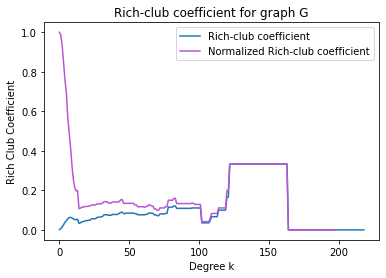

In [29]:
lists = sorted(RC.items()) # sorted by key, return a list of tuples
listsnorm = sorted(RCnorm.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples
v, w = zip(*listsnorm)

plt.plot(x, y, label = 'Rich-club coefficient')
plt.plot(v, w, color = 'mediumorchid', label = 'Normalized Rich-club coefficient')
plt.xlabel("Degree k",fontsize=10)
plt.ylabel("Rich Club Coefficient",fontsize=10)
plt.title('Rich-club coefficient for graph G')
plt.legend()
plt.show()

When we represent the results computed with the two different methods, we can see that for low values of `k`, the results are differents but, as `k` increases, the graphs of the two methods converges. As this coefficient is more relevant for high values of `k`, we could have only computed the non-normalized values that are less complex to compute. 

#### 1.1.4 -  Implement and apply the k-shell decomposition algorithm.

We can first try to make a k-shell with a function `k_shell` directly implemented in the `networkx.algorithms.core` library, for different $k$.

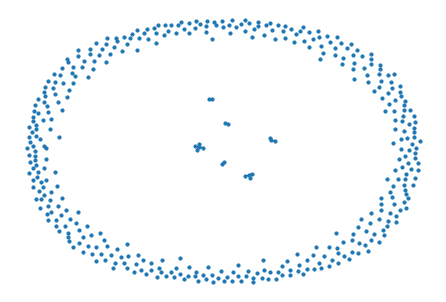

In [30]:
nx.draw(nx.k_shell(G, k=2), node_size = 10)

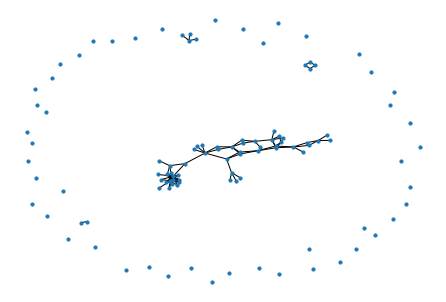

In [31]:
nx.draw(nx.k_shell(G, k=4), node_size = 10)

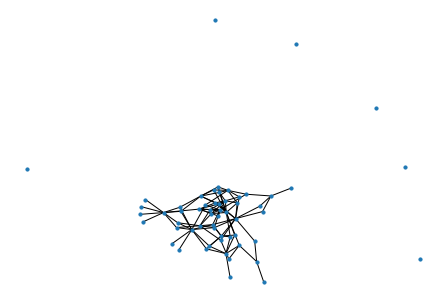

In [32]:
nx.draw(nx.k_shell(G, k=6), node_size = 10)

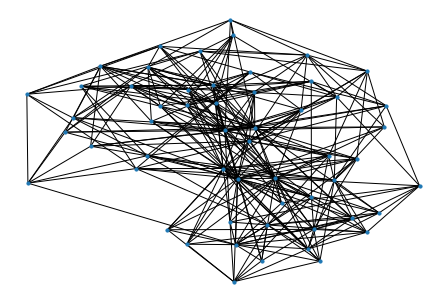

In [33]:
nx.draw(nx.k_shell(G, k=7), node_size = 10)

For $k > 7$ there is no more node left.

Yet we try to implement ourself the `k_shell` function.

In [34]:
def my_kshell (G, k) :
    degrees = []
    GG = G.copy()
    
    ik = 1
    for ik in range(k):
        if len(GG.nodes()) == 0 : # if there are no more nodes in the graph, the loop is exited
            break
        done = False
        while not done :
            rm = []
            
            # nodes of degree <= ik are removed
            for n in GG.nodes():
                if GG.degree(n)<=ik:
                    rm.append(n)       
            for m in rm :
                GG.remove_node(m)
            done = True
            
            # if nothing was removed, there is no need to recheck the degrees
            # the while loop is exited
            if len(rm) == 0 : 
                break
            
            # if there is at least one node of degree <= ik after we've removed nodes
            # the while loop reiterates 
            for n in GG.nodes() :
                if GG.degree(n)<=ik:
                    done = False
                    break
            
    return GG

Time complexity of each loop, $n$ beeing the number of nodes in the entry graph `G` :

- `for ik in range(k) :` $a\leq k$ because the loop is exited if no nodes remain in the G
    - `while not done :` $b$
        - `for n in GG.nodes() :` $n$
        - `for m in rm :` $c$, with `c = len(rm)`
        - `for n in GG.nodes() :` $n-c$
    
As the `for` loop is exited if no nodes remain in the graph and in the worst case where each `while` loop removes nodes one by one, we have $a+b=n$. So the time complexity of `my_kshell` is $O(a\times(n-a)\times(n+c+(n-c))) = O(2n\times a(n-a))$. As $a(n-a)$ is maximised for $a = \frac{n}{2}$, in the worst case senario, the time complexity of `my_kshell` is $O(\frac{n^3}{2})$.

In [35]:
new_G = my_kshell(G, 7)

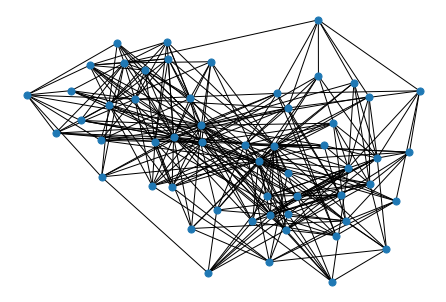

In [36]:
nx.draw(new_G, node_size = 50)

In [52]:
new_tf_nodes = []
new_gn_nodes = []

for x in new_G.nodes :
    if x in tf_nodes :
        new_tf_nodes.append(x)
    elif x in gn_nodes :
        new_gn_nodes.append(x)

In [54]:
new_pos = nx.spring_layout(new_G, iterations=200)

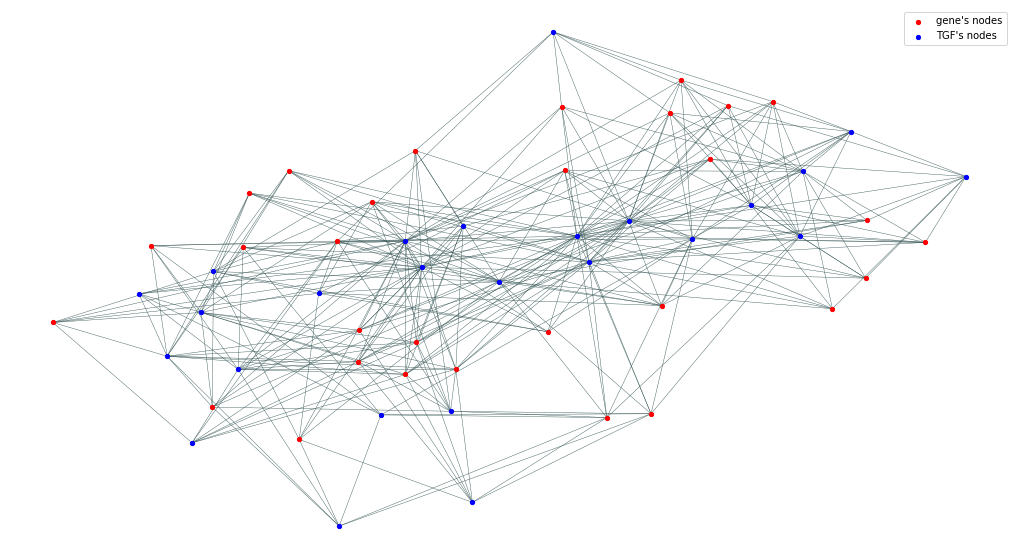

In [56]:
#On rend le graphe plus lisible 
plt.figure(figsize=(18,10))


# nodes
nx.draw_networkx_nodes(new_G, new_pos, nodelist=new_gn_nodes, node_color="r", node_size= 18, label = "gene's nodes")
nx.draw_networkx_nodes(new_G, new_pos, nodelist=new_tf_nodes, node_color="b", node_size= 18, label = "TGF's nodes")

# edges
nx.draw_networkx_edges(new_G, node_size = 18, pos = new_pos, width = 0.4, edge_color = 'DarkSlateGray')

plt.legend()
plt.axis('off')
plt.show()

We could study the components of this k-core by first associating the nodes in it with the genes they represent and there biological function.

In [101]:
def function_in_G(G) :
    name_G = [net4_gene_ids['Name'][net4_gene_ids['ID']==g].values[0] for g in G.nodes] # names of the genes in G

    GO_G = [] # GO of the genes in G
    for name in name_G :
        for go in go_slim_mappingtab[5][go_slim_mappingtab[0] == name] : # GO associated to the gene
                    if isinstance(go, str) : # excudes NaN
                        GO_G.append(go)

    func_G = [go_slim_mappingtab[4][go_slim_mappingtab[5] == go].values[0] for go in GO_G] # functions in new_G
    
    return func_G

In [103]:
def func_count(G) :
    func_G = function_in_G(G)
    
    count_func_G = {} # count of each function in G
    for f in func_G :
        if f not in count_func_G :
            count_func_G[f] = 1
        else :
            count_func_G[f] += 1
    
    return count_func_G

In [108]:
count_func_G = func_count(G) # count of each function in G

In [107]:
count_func_newG = func_count(new_G) # count of each function in new_G

In [113]:
# ratio of count of functions in newG compared to G
func_newG_G = {f : count_func_newG[f]/count_func_G[f] for f in count_func_newG}

### 1.2 - Community detection

#### 1.2.1 - You can choose between the Girvan Newman method and the Louvain algorithm tofind communities in the graph. Describe both algorithms, and their time complexities (explain).

#### The Girvan Newman method :

We can express Girvan-Newman algorithm in the following procedure:
- Calculate edge betweenness for every edge in the graph ;
- Remove the edge with highest edge betweenness ;
- Calculate edge betweenness for remaining edges ;
- Repeat steps 2–4 until all edges are removed.

In its simplest and fastest form - worst-case time $O(E^{2}V$) on a network with $E$ edges and $V$ vertices, or $O(E^{3})$ on a sparse graph (where $V = E$).


#### The Louvain algorithm :

The method consists of two phases :
- The first step is to look for "small" communities by optimizing modularity in a local way, where the modularity quantifies the quality of an assignment of nodes to communities. 
- The second step consist of an aggregation of nodes from the same community and to build a new network whose nodes are the communities. 

These steps are repeated iteratively until a maximum of modularity is attained.

###### The algorithm is:

- Start with each node being a singleton cluster: 
- Consider nodes in random order.
- Iterate as long as cluster membership changes 
     - for each node : remove it from its current cluster and add it to the cluster with the highest modularity gain 
- aggregate the resulting clustering to a new graph and continue on next level (step 1), as long as modularity improves.


The time complexity of the Louvain algorithm is $O(V \log(V))$

#### 1.2.2 - Which algorithm did you choose, why ?

We chose the Louvain method because this method has the best time complexity. Moreover we will use the the module *community* to implement a community detection. By default this module uses the Louvain method.

In [ ]:
louvain_best_partition = community_louvain.best_partition(G, weight='weight')

In [ ]:
louvain_best_partition

In [ ]:
modularity = community_louvain.modularity(louvain_best_partition, G, weight='weight')
print("The modularity Q of G's best partition is {}".format(modularity))

In [ ]:
# pos = nx.spring_layout(G, k=0.6)

In [ ]:
plt.figure(figsize=(18,10))

size = float(len(set(louvain_best_partition.values())))
count = 0

cmap = cm.get_cmap('viridis', max(louvain_best_partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, louvain_best_partition.keys(), node_size=18, cmap=cmap, 
                       node_color=list(louvain_best_partition.values()))
nx.draw_networkx_edges(G, node_size = 18, pos = pos, width = 0.5, 
                       edge_color = 'DarkSlateGray', alpha= 0.6)

plt.axis('off')
plt.show()

A dendrogram is a tree and each level is a partition of the graph nodes.  Level 0 is the first partition, whichcontains the smallest communities, and the best is len(dendrogram) - 1.  The higher the level is, the bigger are the communities

In [ ]:
dendrogram = community_louvain.generate_dendrogram(G)

In [ ]:
dendrogram

In [ ]:
print (" There are ", len(dendrogram) - 1 , "levels")

We have a list of dictionaries in which keys are the nodes and the values are the set it belongs to, and the dictionnaies represent the diffrent levels of partition.

In [ ]:
#We create a dict with the community ID (numbers 1, 2, 3, ...n) as keys 
#and the genes and factors that belong to it as values.

communities_classes = {}

for comm in louvain_best_partition.values():
    communities_classes[comm] = communities_classes.get(comm, [])
    
for gene in louvain_best_partition.keys():
    communities_classes[louvain_best_partition[gene]].append(gene)

In [ ]:
communities_classes

In [ ]:
'''from collections import Counter
louvain_best_partition_ordered = {k : v for k, v in sorted(louvain_best_partition.items(), key = lambda item: item[1])}
comm_size = Counter(louvain_best_partition_ordered.values())'''
comm_size = {c : len(communities_classes[c]) for c in communities_classes}

In [ ]:
comm_size 

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,10))
plt.xticks(np.arange(0, 300, step=10), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Communities ID ",fontsize=20)
plt.ylabel("Number of nodes per community",fontsize=20, )
plt.title("Plot of the communities fund with the best partition detection", fontsize=20)


plt.plot([c for c in sorted(comm_size.keys())], [n for n in comm_size.values()])
plt.show()

In [ ]:
len(communities_classes[2])

We can see that the community 0 has the biggest number of nodes. It means that in this community, there is a bigger interaction between genes dans factors than in the others.

#### 1.2.3 - For the the Girvan Newman method, the user should select one of the output partitions, explain the criterion that could be used to make this choice, and its complexity.

#### 1.2.4 - Study the GO composition of each community.  To do this you can produce a countingmatrix $M$,  such  that $M_{i,j}$ is  the  number  of  genes  from  community $j$ that  have  GO annotation $i^1$.

In [ ]:
# extraction of all the GO in the file go_slim_mappingtab
GO_rep = [go for go in go_slim_mappingtab[5]]
GO_unsorted = []
for go in GO_rep :
    if isinstance(go, str) and go not in GO_unsorted :
        GO_unsorted.append(go)
GO = sorted(GO_unsorted)

In [ ]:
GO_comm = {go : [0]*len(comm_size.keys()) for go in GO} # dict GO : [n° of occurence in each community]

for comm in communities_classes :
    for gene in communities_classes[comm] : 
        
        # for each gene in each community
        # count the number of occurence of each GO
        
        name = net4_gene_ids['Name'][net4_gene_ids['ID'] == gene].values[0] # name of the gene
        for go in go_slim_mappingtab[5][go_slim_mappingtab[0] == name] : # GO associated to the gene
            if isinstance(go, str) : # excudes NaN
                GO_comm[go][comm] += 1 


In [ ]:
M0 = pd.DataFrame(data = GO_comm)
M0

#### 1.2.5 - Is there a relationship between graph communities and particular cell functions ?

Firstly we are going to exclude the GO having too many counts as they denote too general features.

In [ ]:
# suppression of GO with too many counts

GO_sum = [sum(M0[go])for go in M0.columns] # Total number of nodes of each GO

In [ ]:
# graphical representation of GO_sum : boxplot representation
plt.figure(figsize=(15,10))
plt.ylabel("Number of nodes",fontsize=20)
plt.title("Total number of nodes of each GO in the network", fontsize=20)

plt.boxplot(GO_sum)
plt.show()

As we can see we have several outliers that have a high number of nodes corresponding to their GO annotation. We will now remove the corresponding GO annotations from our study.

In [ ]:
IQR = np.percentile(GO_sum, 75) - np.percentile(GO_sum, 25) # interquartil range
maxGOaccepted = np.percentile(GO_sum, 75) + 1.5*IQR # count threshold 

In [ ]:
GO_del = [go for go in M0.columns if sum(M0[go])>maxGOaccepted] # GO with counts over the threshold
M1 = M0.copy() 
for go in GO_del :
    M1.pop(go)
# M1 is the matrix M0 with columns corresponding to GO with counts over the threshold removed

In [ ]:
M1.shape < M0.shape # test that columns have been deleted

Let's test for each GO if it's equaly represented in each community. To do so we will do a chi2 test for each G0 we have in the matrix. The null hypothesis $H_0$ of our test is the following :

$H_0$ : "The proportion of G0 is the same in all the communitites"

In [ ]:
M = M1

In [ ]:
# quadratic distance between observed values and theoretical values calculated under H_0
E = {go : 0 for go in M.columns}
for go in M.columns :
    i = range(len(communities_classes)) # communitites
    ki = M[go].values # proportion of go in each community i
    if sum(ki) != 0 :
        ni = [comm_size[x] for x in i] # size of each community i
        p_star = sum(ki)/sum(ni) # proportion of go in all the community under H_0
        ki_star = [p_star*n for n in ni]
        non_ki_star = [(1-p_star)*n for n in ni]
        E[go] = sum( (ki - ki_star)**2/ki_star + ((ni-ki) - non_ki_star)**2/non_ki_star )

In [ ]:
# computation of the p-value of the chi2 test for each GO

GO_p = {go : None for go in M.columns} # p-values

for go in M.columns :
    k = [m for m in M[go].values] # proportion of genes with the annotation go in each community
    
    if sum(k) == 0 : # if no genes has the annotation go
        GO_p[go] = 1
        
    else :
        n = [comm_size[comm] for comm in sorted(comm_size.keys())] # size of each community
        nonk = [n[i] - k[i] for i in range(len(communities_classes))] # not k
        cont = [k, nonk] # contingency table
        GO_p[go] = st.chi2_contingency(cont)[1] # p-value for go

In [ ]:
alpha = 0.0001 # risk of rejecting H_0 while H_0 true of 0.01%

# GO that aren't represented equaly throughout the communities with a risk alpha 
H0_rejected = [go for go in M.columns if GO_p[go] < alpha] 

In [ ]:
M[H0_rejected] # Corresponding columns in M

In [ ]:
# cell function corresponding to the GO annotation 
cell_func = [go_slim_mappingtab[4][go_slim_mappingtab[5] == go].values[0] for go in H0_rejected] 
cell_func_df = pd.DataFrame(data = np.asarray(M[H0_rejected]), columns=gne)

In [ ]:
# displaing the matrix of the rejected columns with the cell function names associated
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
cell_func_df 

In [ ]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

The risk $\alpha$ taken is very low and we still have a lot of cell functions that are particularly more represented in some communities so we can say that there is a relationship between graph communities and particular cell functions.

## 2 - Around the Traveling Salesman Problem
### 2.1 - Exact solution
#### 2.1.1 - Number of Hamiltonian paths in a complete graph

In a complete graph, every node is adjacent to every other node. Let $G = (V, E)$ a complete graph with $|V| = n$. Let's define an Hamiltonian path $(x_0, x_1, x_2,...,x_n)$ in $G$. There are $n$ possible starting nodes $x_0$. Then, as one of the $n$ nodes has already been visited, only $n-1$ options are left for $x_1$, $n-2$ for $x_2$ and so on until there is only one node left unvisited : $x_n$. Thus, there are $n\times n-1 \times n-2 \times ... \times 1 = n!$ distinct Hamiltonian paths in a complete graph of size $n$.

#### 2.1.2 - Test graphs creation

In [ ]:
# Creating a complete graph to test our functions
Gc = nx.Graph()
Gc = nx.complete_graph(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
list(Gc.nodes())

In [ ]:
def add_weight(G) : 
    # Modifies G to add a random int weight in ]0,10]
    # G : networkX graph
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = random.randrange(0,10)+1
        #print(e, Gc[e[0]][e[1]]['weight']) 
    return None

In [ ]:
def draw_weight(G):
    # Draws the graph G where each edge's width is proportional to its weight
    # G : weighted networkX graph
    
    edge_width = [d['weight'] for (u, v, d) in G.edges(data=True)] # weight of the edges of G

    pos = nx.spring_layout(G)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos)

    # edges
    nx.draw_networkx_edges(G, pos, width=edge_width)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    plt.axis("off")
    plt.show()
    
    return None

In [ ]:
add_weight(Gc)

In [ ]:
draw_weight(Gc)

In [ ]:
# Creation of a different graph to test our functions
Gtest = nx.petersen_graph()

In [ ]:
add_weight(Gtest)

In [ ]:
draw_weight(Gtest)

#### 2.1.3 - Enumeration of Hamiltonian paths

In [ ]:
def next_step(G, si, path, weight, path_weight) :
    # Step to compute all possible paths that go as deep as possible from si without any nodes already in path,
    # also computes corresponding weight of these paths
    # G : weighted networkX graph
    # si : node of G, active node
    # path : list of nodes of G, active path
    # weight : int, weight of the active path
    # path_weight : list of tuples (path, weight), 
    # each path is represented as a list of nodes, its total weight as an int
    
    if len(path)>0 : # if si is not the fist node of the path
        sp = path[len(path)-1] # last node in path
        si_w = G[sp][si]['weight'] # weight of the edge between sp and si
        weight = weight + si_w # weight update
        
    path = path + [si] # si is added to the path
    
    # si_succ is filled with the successors of si that are not already in path
    si_succ = [] 
    for sj in G[si] :
        if sj not in path :
            si_succ.append(sj)
    
    # next_step is called for each succesor sj
    for sj in si_succ :
        next_step(G, sj, path, weight, path_weight)
    
    # when each branch has been visited as deep as possible, the list of pathecessor is added to path
    if len(si_succ) == 0 :
        path_weight.append((path, weight))
    
    return None

In [ ]:
def Hamiltonian_path(G, s0) :
    # Computes the the possible Hamiltonian paths in G starting at node s0
    # G : weighted networkX graph
    # s0 : node in G
    # returned value : list of tuples (path, weight)
    # each path is represented as a list of nodes, its total weight as an int
    
    # computing all possible paths that go as deep as possible and start at s0 and their corresponding weight
    
    path = [] # active path
    path_weight = [] # list of tuples (path, weight) to contain the paths and their weight
    weight = 0 # weight of the active path
    
    # first step
    # active node : s0
    next_step(G, s0, path, weight, path_weight) 
    
    
    # Filtering path_w to keep only the Hamiltonian paths 
    
    n = len(G.nodes()) # size of G
    ham_path = [] 
    for tup in path_weight :
        if len(tup[0]) >= n :
            ham_path.append(tup)
          
    return ham_path

In [ ]:
Hamiltonian_path(Gtest, 1)

In [ ]:
Gc_path = Hamiltonian_path(Gc, 'a')
Gc_path

In [ ]:
N_Gc_path = len(Gc_path) # number of Hamiltonian paths found starting at node 'a' in Gc
n = len(Gc.nodes()) # size of Gc
print(N_Gc_path == math.factorial(n-1)) # test N_Gc_path == (n-1)!

As we showed before, we can find $n!$ Hamiltonian paths in a complete graph of size $n$. Here we know the starting node $n_1$ so we don't have the $n$ options for $n_1$ but only one, so we end up with $\frac{n!}{n} = (n-1)!$ Hamiltonian paths.

#### 2.1.4 - Shortest Hamiltonian path

In [ ]:
def shortest_path(path_w) :
    # returns the shortest(s) path(s) of path_w
    # if there are several paths of the same minimal weight they will be all returned
    # path_w : list of tuples (path, weight)
    # each path is represented as a list of nodes, its total weight as an int
    # returned value : tuples (path, weight) 
    
    w_min = path_w[0][1] # minimal weight initialisation
    path_min = [] # shortest path initialisation
    
    # searching for the lowest weight
    for tup in path_w :
        if tup[1] < w_min : # if a lower weight is found
            w_min = tup[1] # minimal weight actualisation
            path_min = [tup] # shortest path actualisation
        elif tup[1] == w_min : # if there is a path of the same weight as path_min
            path_min.append(tup) # this path is added to the list of shortest paths
            
    return path_min

In [ ]:
def shortest_ham_path(G, s0) :
    # returns the shortest(s) Hamiltonian path(s) in G starting at node s0
    # if there are several paths of the same minimal weight they will be all returned
    # G : weighted networkX graph
    # s0 : node in G
    # returned value : list of tuples (path, weight)
    # each path is represented as a list of nodes, its total weight as an int
    
    path_w = Hamiltonian_path(G, s0)
    path_min = shortest_path(path_w)
            
    return path_min
    

In [ ]:
Gc_min_path = shortest_ham_path(Gc, 'a')
Gtest_min_path = shortest_ham_path(Gtest, 1)

In [ ]:
print('Gc_min_path', Gc_min_path)
print('Gtest_min_path', Gtest_min_path)

In the research of all Hamiltonian paths, `si_succ`, on which we loop, gets smaller as we go deeper. For `si = s0`, the maximum size of `si_succ` is $n$ (if we can have an edge that liks `si` to itself), then as we go a step deeper, the maximum size of `si_succ` is $n-1$, then $n-2$, and so on. The time complexity of the method `Hamiltonian_path` is $O(n!)$.

#### 2.1.5 - Traveling Salesman exact solution

In [ ]:
def Traveling_Salesman(G) :
    # Returns all possible solutions to the traveling salesman problem for the graph G
    # G : weighted networkX graph
    # returned value : list of tuples (path, weight)
    # each path is represented as a list of nodes, its total weight as an int
    
    # searching shortests Hamiltonian paths in G for each of its nodes as starting node
    path_w = []
    for s in G.nodes() :
        path_w = path_w + Hamiltonian_path(G, s)
    
    # finding the shortest(s) path(s) in the Hamilton paths found
    path_min = shortest_path(path_w)
    
    return path_min

In [ ]:
Traveling_Salesman(Gc)

In [ ]:
Traveling_Salesman(Gtest)

### 2.2 - The Nearest Neighbor heuristic

In [ ]:
def nearest_neighbour(G, s0) :
    # Implementation of the nearest neighbour heuristic
    # Parameters :
    # G : weighted networkX graph
    # s0 : node in G
    # Return value : tuple
    # list of nodes, shortest Hamiltonian path starting at s0
    # int, total weight of the path
    # list of the nodes left unvisited
    
    shortest_path = [] # returned path
    spath_w = 0 # total weight of the path
    n = G.number_of_nodes() 
    
    si = s0 # active node, initialised as s0
    shortest_path.append(si) # si is added to the path
    
    while len(shortest_path) < n : # while there are still unvisited nodes in G
        # the neighbors of si that has not been visited yet are stored in succ
        succ = [] 
        for sj in G[si] :
            if sj not in shortest_path :
                succ.append(sj)
        
        succ_weight = [(s, G[si][s]['weight']) for s in succ] # weight of the edge linking si to its neighbors
        
        if len(succ) == 0 : # If there are no successor
            return (shortest_path, spath_w, G.nodes()-shortest_path)
        
        # fiding the edge with the minimal weight
        min_w = succ_weight[0][1] # minimal weight initialisation
        min_s = succ_weight[0][0] # corresponding successor node
        
        for tupNW in succ_weight :
            if tupNW[1] < min_w : # if a lower weight is found
                min_w = tupNW[1] # min_w actualisation
                min_s = tupNW[0] # min_s actualisation
       
        shortest_path.append(min_s) # the closest successor is added to the path
        spath_w = spath_w + min_w
        si = min_s # the closest successor is now the active node
    
    return (shortest_path, spath_w)

In [ ]:
nearest_neighbour(Gtest, 5)

In [ ]:
nearest_neighbour(Gc, 'f')

Time complexity of each loop :

- `while len(shortest_path) < n :` $n$
    - `for sj in G[si] :` $n$
    - `for tupNW in succ_weight :` $n$
    
So the time complexity of `nearest_neighbour` is $O(n \times (n+n)) = O(2n^2)$.

In [ ]:
Gex = nx.Graph()
Eex = [(0, 1, {'weight': 4}), (0, 4, {'weight': 4}), (0, 5, {'weight': 2}), (1, 2, {'weight': 8}), (1, 6, {'weight': 1}), (2, 3, {'weight': 5}), (2, 7, {'weight': 4}), (3, 4, {'weight': 8}), (3, 8, {'weight': 8}), (4, 9, {'weight': 10}), (5, 7, {'weight': 6}), (5, 8, {'weight': 8}), (6, 8, {'weight': 5}), (6, 9, {'weight': 2}), (7, 9, {'weight': 7})]
Gex.add_edges_from(Eex)

In [ ]:
nearest_neighbour(Gex, 9)

In [ ]:
Traveling_Salesman(Gex)

In [ ]:
nearest_neighbour(Gex, 8)

But it fails to find the shortest Hamiltonian path in some cases, for example, in `Gex`, with `9` as a starting node, this method does not create an Hamiltonian path. And for `8` as a starting node, it creates an Hamiltonian path but not the shortest.

### 2.3 - The Minimum Spanning Tree heuristic (MST)

#### 2.3.1 - Time complexity of Prim's algorithm

If an **adjacency list** is used to represent the graph, using a  **Breadth First Search (BFS)**, all the vertices can be browsed in  $O(V + E)$ time.

Then we can use a **min heap** as a priority queue to store vertices not yet included in the MST and to get the minimum weight edge.

A Heap is a special Tree-based data structure in which the tree is a complete binary tree. In a Min-Heap the key present at the root node must be minimum among the keys present at all of it’s children. The same property must be recursively true for all sub-trees in that Binary Tree.

A **min heap** opération has a complexity time of $O(\log(V))$

Thus we have a total time compelxity of :
\begin{align*}
    & = O(V + E) \times O(\log(V)) \\
    & = O((V + E)\log(V)) \\
\end{align*}

#### 2.3.2 - Prove that during each iteration of the while loop, the subgraph (W, F ) is a tree.

##### Initialisation :
For the first iteration, $W = W_0 = \{x_0\}$ and $F = F_0 = \emptyset$. 

> Let $(x, y) \in E$ the shortest edge such that $x \in W$ and $y \notin W$

- $x_0$ is the only element that is in $W_0$ so $x = x_0$ ;

- let $x_1$ the closest neighbor of $x_0$, $y = x_1$.

> $W \gets W \cup y$

> $F \gets F \cup (x, y)$

We now have $W = W_1 = \{x_0, x_1\}$ and $F = F_1 = \{(x_0, x_1)\}$.

$(W, F) = (W_1, F_1)$ consist of only two nodes linked by one edge so it's an acyclic and connected graph, we can say that we have a tree at the end of this first iteration.

##### Heredity :
Let's suppose that at the end of the $n^{th}$ iteration we have a tree $(W, F) = (W_n, F_n)$ with $W_n = \{ x_0, x_1, ..., x_n\}$.

> Let $(x, y) \in E$ the shortest edge such that $x \in W$ and $y \notin W$

- let $(x_i, x_{n+1}) \in E$ the shortest edge such that $x_i \in W_n$ and $x_{n+1} \notin W_n$ ;
- we thus have $x = x_i$ and $y = x_{n+1}$.

> $W \gets W \cup y$

> $F \gets F \cup (x, y)$

At the end of this $(n+1)^{th}$ iteration we have $(W, F) = (W_{n+1}, F_{n+1})$ with $W_{n+1} = \{ x_0, x_1, ..., x_n, x_{n+1}\}$ and $F_{n+1} = F_n \cup \{(x_i, x_{n+1})\}$.

As $(W_n, F_n)$ is a tree and that we created $(W_{n+1}, F_{n+1})$ by adding one node $x_{n+1}$ and connecting it to the tree $(W_n, F_n)$ with one edge $(x_i, x_{n+1})$, $(W_{n+1}, F_{n+1})$ is connected and is acyclic because we didn't add any edge between two nodes of $(W_n, F_n)$.
(
##### Conclusion :
We have shown that :
- at the end of the first iteration of the `while` loop $(W, F)$ ;
- if we have a subgraph $(W, F) = (W_n, F_n)$ that is a tree as a precondition to any iteration, we end up with the subgraph $(W, F) = (W_{n+1}, F_{n+1})$ that is also a tree at the end of the iteration.

We can thus say that, according the recurrence principle, the subgraph $(W, F)$ that we have when the exiting condition of the `while` loop $W \neq V$ is met is a tree and that $(W, F) = (V, F)$. So the subgraph $(V, F)$ returned at the end of Prim's algorithm is a tree.

#### 2.3.3 - Show that the result of Prim’s algorithm is a MST

We know that, if $(V, F)$ if a tree, then $|F| = |V|-1$, therefore, there is a fixed number of edges in $F$. The only way to minimize the sum of the weights of the edges of a spanning tree is to minimize each weight as we can't minimize the number of edges. At each iteration of the while loop, Prim's algorithm selects the shortest edge possible to attatch a new node to the tree so we can say that it returns a minimum spanning tree.

#### 2.3.4 - Write a Python function that implements Prim’s algorithm.

In [ ]:
def prims_algo(G,start):
    # Function that recives a graph G and a starting node start, and returns a Minimum Spannin Tree MST
    # G : weighted NetworkX graph
    # start : node of G
    # returned value : 
    
    N = len(G) - 1 
    current = start # current node
    visited = set() # We store all the visited nodes
    pq = pqdict.PQDict() #from the module pqdict (priority queue dictionnary) :
    MST = []

    while len(MST) < N:
        # filling pq with the edges linking current node to its neighbors not already visited
        for node in G.neighbors(current):
            if node not in visited and current not in visited:
                if (current,node) not in pq and (node,current) not in pq:
                    w = G[current][node]['weight']
                    pq.additem((current,node), w)

        visited.add(current)
        edge_, weight_ = pq.popitem() # We get the last tuple of the priority queue with its weight (lower weight edge)
        
        # removing potential edges that goes to a visited node
        while(edge_[1] in visited):
            edge_, weight_ = pq.popitem()
            
        MST.append(edge_)
        current = edge_[1]


    return MST

In [ ]:
MSTtest = prims_algo(Gc, 'a')
MSTtest

In [ ]:
other_edges = [n for n in Gc.edges() if n not in MSTtest]
other_edges

In [ ]:
pos = nx.spring_layout(Gc)

# nodes
nx.draw_networkx_nodes(Gc, pos, node_size=500)

# edges
nx.draw_networkx_edges(Gc, pos, edgelist=other_edges, width=4, alpha=0.5, edge_color='b', style='dashed')
nx.draw_networkx_edges(Gc, pos, edgelist=MSTtest, width=4)

# labels
nx.draw_networkx_labels(Gc,pos,font_size=20,font_family='sans-serif')

plt.axis('off')
plt.show()

The triangular inequality is the following inequality:
\begin{equation*}
    \forall x, y, z \in V, w(x, z) \leq w(x, y) + w(y, z),
\end{equation*}

where $w(x, y)$ is the weight of edge $x → y$ (more direct paths are shorter).

#### 2.3.5 - Assuming that the graph verifies the triangle inequality, show that the length of the Hamiltonian cycle obtained by visiting the MST is less than twice the length of the shortest Hamiltonian cycle of the graph.

Take the shortest Hamiltonian cycle called $H_s$ and remove an arbitrary edge. The résult is a spannig tree called $T$. So we can first write the following equality if we consider that all edge have a non-negative weight :


> $length(T) \leq length (H_s)$


Now, let $P$ be the full path of the Minimum Spanning Tree (MST) denoted by $T_{MST}$. This full path will include repeated vertices. 

Example : {0, 1, 2, 1, 7, 1, 0, 3, 4, 5, 6, 4, 3, 0}

So as you can imagine the full path $P$ traverses every edges of the $T_{MST}$ twice. So we have :


> $length(P) = 2 \times length (T_{min})$

> $length(P) = 2 \times length (T_{min}) \leq length(T)$

> $length(P) = 2 \times length (T_{min}) \leq length(T) \leq length(H_s)$

The problem is $P$ is not a proper cycle since come vertices may be visited more than once. So by using the **triangle inequality**, we delete a visit to every vertices from $P$ to obtain a proper Hamiltonian cycle denoted $H$ where the **weight does not increase**.

In our example : {0, 1, 2, 7, 3, 4, 5, 6, 0}

Then we get :


> $length(H) \leq length (P)$

> $length(H) \leq length (P) \leq 2 \times length (T_{min})$

> $length(H) \leq length (P) \leq 2 \times length (T_{min}) \leq length(T) \leq length(H_s)$


So finaly we have :


> $length(H) \leq 2 \times length (H_s)$



QED.